### Good results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo


def run_one_method(method, temperatures, Lx, Ly, J, warmup, steps):
    Mabs_mean, Mabs_err = [], []
    Chi_mean,  Chi_err  = [], []
    Tau_list            = []

    for T in temperatures:
        lat = IsingLattice(Lx, Ly, J=J)      # J = -1.0 for ferro with your ΔE
        mc  = MonteCarlo(lat)
        mc.run_loop(warmup_steps=warmup, steps=steps, T=T, method=method)

        m = np.asarray(mc.acc.magnetization)   # raw magnetization series (can be ±)
        # order parameter
        m_abs = np.abs(m)
        acf   = mc.acc.autocorr_fft(m)                # use raw m for tau
        tau   = mc.acc.tau_int_from_acf(acf)
        Tau_list.append(tau)

        # errors with correlated samples: sigma ≈ sqrt( var * 2*tau / N )
        N   = m.size
        Mabs_mean.append(m_abs.mean())
        Mabs_err.append(np.sqrt(m_abs.var(ddof=1) * 2.0 * tau / N))

        # susceptibility from fluctuations (Z2-symmetric definition)
        Chi_mean.append(np.mean(mc.acc.susceptibility))
        Chi_err.append(np.sqrt(np.var(mc.acc.susceptibility,ddof=1) * 2.0 * tau / N))

    return (np.array(Mabs_mean), np.array(Mabs_err),
            np.array(Chi_mean),  np.array(Chi_err),
            np.array(Tau_list))

# ---------- parameters ----------
temperatures = np.linspace(1.5, 3.0, 31)
Lx = 10; Ly = 10              # 8×8 is very noisy near Tc; 32×32 is a good start
J_fm = -1.0                   # IMPORTANT: negative for ferro with your ΔE formula

# Heavier sampling for Metropolis (critical slowing down)
warmup_w = 100; steps_w = 1_000
warmup_m = 100_000; steps_m = 1_000_000

# ---------- run both ----------
Mw, Mw_err, Chiw, Chiw_err, Tauw = run_one_method("wolff",      temperatures, Lx, Ly, 1, warmup_w, steps_w)
Mm, Mm_err, Chim, Chim_err, Taum = run_one_method("metropolis", temperatures, Lx, Ly, J_fm, warmup_m, steps_m)



Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3475.93it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3485.19it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4062.04it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 4218.85it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5797.08it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5431.69it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5996.23it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 4811.43it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4832.43it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5245.35it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6119.94it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5444.02it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6112.90it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5610.76it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6531.35it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5644.07it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5579.91it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5775.55it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6642.55it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5793.38it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5937.49it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5834.28it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6839.36it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5944.38it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7172.33it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6286.10it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6580.33it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6530.86it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7824.32it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6586.18it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7808.30it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7198.54it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8163.30it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7338.18it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7837.33it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7866.97it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9989.29it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8560.87it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10482.62it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 9629.77it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11349.45it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10108.85it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 12908.73it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11004.25it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 11778.11it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11938.84it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 14604.63it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 12811.57it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 15812.05it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13828.35it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 18613.22it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 14736.82it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 18499.11it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 15304.38it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 18727.92it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 16047.44it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 21926.42it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 16596.58it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 20448.05it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 17128.98it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 22537.90it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 18093.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 93893.87it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39219.96it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103533.00it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39003.81it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107718.72it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40391.12it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111479.78it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40593.72it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109925.84it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37782.98it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102235.49it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37455.26it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102329.75it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37819.65it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 95371.39it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37502.01it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 101321.46it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 38302.43it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104039.59it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37631.05it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102872.07it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37351.90it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104714.66it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37529.86it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 99140.16it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37663.86it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100274.53it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37652.93it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 99420.21it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37801.77it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 96269.56it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37765.88it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104131.44it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37323.86it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100455.59it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 38133.25it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100233.38it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37783.93it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102257.55it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37516.02it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100578.85it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37484.65it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102613.22it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37904.20it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100176.65it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37729.71it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 101770.00it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37875.50it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106413.82it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37847.01it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104500.78it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37372.46it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 96979.38it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 38066.68it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 101501.55it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 38313.57it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103059.24it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37919.35it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109141.26it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37832.57it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106283.42it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:26<00:00, 37652.94it/s]


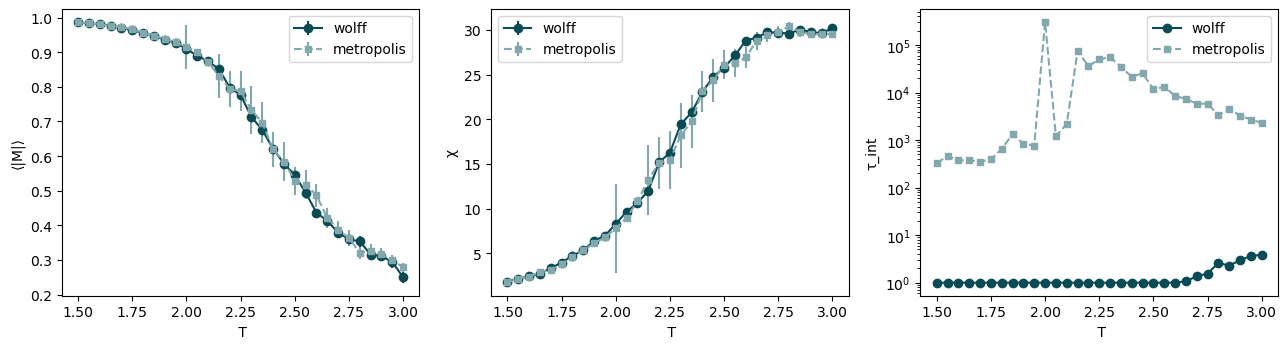

In [ ]:

from matplotlib.colors import ListedColormap

SPIN_CMAP = ListedColormap(["#094B55", "#82a8ae"])
c_dark, c_light = SPIN_CMAP.colors 
# ---------- plot ----------
fig, axs = plt.subplots(1, 3, figsize=(13, 3.6))

# ⟨|M|⟩
axs[0].errorbar(temperatures, Mw, yerr=Mw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[0].errorbar(temperatures, Mm, yerr=Mm_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[0].set_xlabel(" T")
axs[0].set_ylabel("⟨|M|⟩")
axs[0].legend()

# χ
axs[1].errorbar(temperatures, Chiw, yerr=Chiw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[1].errorbar(temperatures, Chim, yerr=Chim_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[1].set_xlabel(" T")
axs[1].set_ylabel("χ")
axs[1].legend()

# τ_int
axs[2].plot(temperatures, Tauw, 'o-',  ms=6, label='wolff',c=c_dark)
axs[2].plot(temperatures, Taum, 's--', ms=4, label='metropolis',c=c_light)
axs[2].set_xlabel(" T")
axs[2].set_yscale('log')
axs[2].set_ylabel("τ_int")
axs[2].legend()

# plt.savefig('ising_test')

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ising_lattice import IsingLattice
from monte_carlo import MonteCarlo


def run_one_method(method, temperatures, Lx, Ly, J, warmup, steps):
    Mabs_mean, Mabs_err = [], []
    Chi_mean,  Chi_err  = [], []
    Tau_list            = []

    for T in temperatures:
        lat = IsingLattice(Lx, Ly, J=J)      # J = -1.0 for ferro with your ΔE
        mc  = MonteCarlo(lat)
        mc.run_loop(warmup_steps=warmup, steps=steps, T=T, method=method)

        m = np.asarray(mc.acc.magnetization)   # raw magnetization series (can be ±)
        # order parameter
        m_abs = np.abs(m)

        acf   = mc.acc.autocorr_fft(m)                # use raw m for tau
        tau   = mc.acc.tau_int_from_acf(acf)
        Tau_list.append(tau)

        N   = m.size
        Mabs_mean.append(m_abs.mean())
        Mabs_err.append(np.sqrt(m_abs.var(ddof=1) * 2.0 * tau / N))

        Chi_mean.append(np.mean(mc.acc.susceptibility))
        Chi_err.append(np.sqrt(np.var(mc.acc.susceptibility,ddof=1) * 2.0 * tau / N))

    return (np.array(Mabs_mean), np.array(Mabs_err),
            np.array(Chi_mean),  np.array(Chi_err),
            np.array(Tau_list))

temperatures = np.linspace(1.5, 3.0, 31)
Lx = 10; Ly = 10           
J_fm = -1.0                  

# Heavier sampling for Metropolis (critical slowing down)
warmup_w = 100; steps_w = 1_000
warmup_m = 100_000; steps_m = 1_000_000

# ---------- run both ----------
Mw, Mw_err, Chiw, Chiw_err, Tauw = run_one_method("wolff",      temperatures, Lx, Ly, J_fm, warmup_w, steps_w)
Mm, Mm_err, Chim, Chim_err, Taum = run_one_method("metropolis", temperatures, Lx, Ly, J_fm, warmup_m, steps_m)



Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 2322.45it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3196.40it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3670.01it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3246.41it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3736.31it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 2938.41it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3403.20it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3097.14it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3463.33it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3135.68it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3501.67it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3167.94it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3300.13it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 2996.46it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3739.14it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3394.10it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3693.14it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3352.38it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4035.74it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3481.42it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3931.30it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3519.48it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3783.12it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3577.40it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4206.21it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3709.17it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 3985.24it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3778.79it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4264.11it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 3912.55it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5130.90it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 4425.92it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 4919.89it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 4832.36it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 5730.16it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5128.62it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6116.73it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 5634.04it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 6500.38it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6093.27it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7451.64it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 6505.00it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 7309.19it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 7414.07it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9171.69it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 8175.01it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 8394.65it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 9184.54it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 9849.48it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 9576.52it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 10164.31it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10555.51it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 14710.66it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 10676.44it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 12194.87it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 11697.77it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 15159.95it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 12444.34it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 14756.73it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 13013.62it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 17344.74it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:00<00:00, 14338.81it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108744.06it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39783.84it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106757.84it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40207.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 98793.44it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41086.77it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109101.68it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40110.54it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 101121.83it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40062.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110967.82it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39684.67it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 112006.92it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:23<00:00, 41841.84it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111548.41it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40153.34it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107188.41it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41116.06it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 112250.89it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40603.59it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107177.57it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39568.48it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107568.38it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40743.57it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109644.46it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39867.06it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 112810.36it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40153.12it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110088.63it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39962.50it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105562.52it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39935.02it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111863.26it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40638.62it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103796.85it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:23<00:00, 41990.01it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111629.28it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:23<00:00, 41781.90it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110602.52it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41026.38it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108976.47it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:25<00:00, 39837.14it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 116715.29it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40739.13it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 111291.77it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41203.79it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103915.04it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41556.18it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106399.81it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40894.00it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 109636.49it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40743.47it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 116144.27it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40794.05it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108394.60it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40834.80it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 91816.45it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40479.68it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106553.15it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 41158.02it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105461.76it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [00:24<00:00, 40518.31it/s]


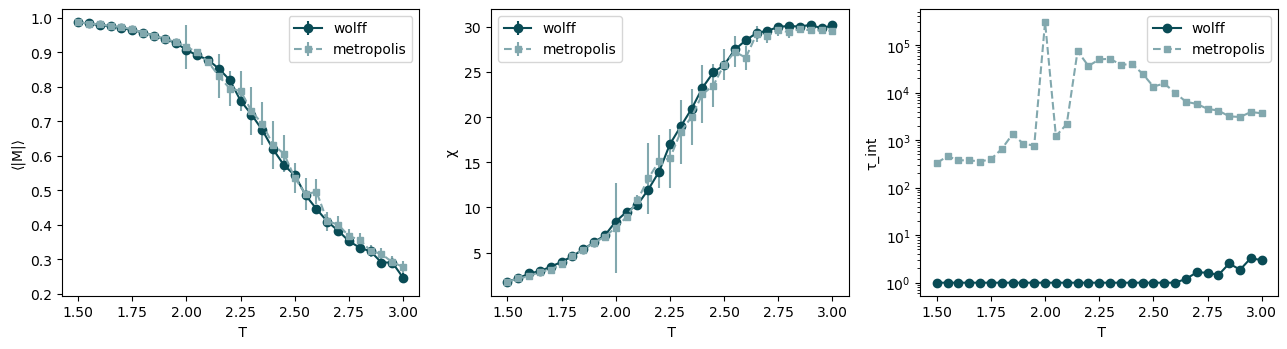

In [2]:

from matplotlib.colors import ListedColormap

SPIN_CMAP = ListedColormap(["#094B55", "#82a8ae"])
c_dark, c_light = SPIN_CMAP.colors 
# ---------- plot ----------
fig, axs = plt.subplots(1, 3, figsize=(13, 3.6))

# ⟨|M|⟩
axs[0].errorbar(temperatures, Mw, yerr=Mw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[0].errorbar(temperatures, Mm, yerr=Mm_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[0].set_xlabel(" T")
axs[0].set_ylabel("⟨|M|⟩")
axs[0].legend()

# χ
axs[1].errorbar(temperatures, Chiw, yerr=Chiw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[1].errorbar(temperatures, Chim, yerr=Chim_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[1].set_xlabel(" T")
axs[1].set_ylabel("χ")
axs[1].legend()

# τ_int
axs[2].plot(temperatures, Tauw, 'o-',  ms=6, label='wolff',c=c_dark)
axs[2].plot(temperatures, Taum, 's--', ms=4, label='metropolis',c=c_light)
axs[2].set_xlabel(" T")
axs[2].set_yscale('log')
axs[2].set_ylabel("τ_int")
axs[2].legend()

# plt.savefig('ising_test')

plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lattice import Lattice
from monte_carlo import MonteCarlo
        

def run_one_method(method, temperatures, rows, cols, doping, kf, J0, warmup, steps):
    Mabs_mean, Mabs_err = [], []
    Chi_mean,  Chi_err  = [], []
    Tau_list            = []

    for T in temperatures:
        lat = Lattice(rows=rows,cols=cols,doping=doping,kf=kf,J0=J0)      # J = -1.0 for ferro with your ΔE
        mc  = MonteCarlo(lat)
        mc.run_loop(warmup_steps=warmup, steps=steps, T=T, method=method)

        m = np.asarray(mc.acc.magnetization)   # raw magnetization series (can be ±)
        # order parameter
        m_abs = np.abs(m)

        acf   = mc.acc.autocorr_fft(m)                # use raw m for tau
        tau   = mc.acc.tau_int_from_acf(acf)
        Tau_list.append(tau)

        N   = m.size
        Mabs_mean.append(m_abs.mean())
        Mabs_err.append(np.sqrt(m_abs.var(ddof=1) * 2.0 * tau / N))

        Chi_mean.append(np.mean(mc.acc.susceptibility))
        Chi_err.append(np.sqrt(np.var(mc.acc.susceptibility,ddof=1) * 2.0 * tau / N))

    return (np.array(Mabs_mean), np.array(Mabs_err),
            np.array(Chi_mean),  np.array(Chi_err),
            np.array(Tau_list))

temperatures = np.linspace(1., 12.0, 31)
rows, cols = 30, 30
doping = 0.3
kf = 0.3
J0 = -1               

# Heavier sampling for Metropolis (critical slowing down)
warmup_w = 100; steps_w = 1_000
warmup_m = 100_000; steps_m = 1_000_000

# ---------- run both ----------
Mw, Mw_err, Chiw, Chiw_err, Tauw = run_one_method("wolff",      temperatures, rows, cols, doping, kf, J0, warmup_w, steps_w)
Mm, Mm_err, Chim, Chim_err, Taum = run_one_method("metropolis", temperatures, rows, cols, doping, kf, J0, warmup_m, steps_m)



/home/lisa/Desktop/proj/monte-carlo-PtSe2/lattice.py:69: RuntimeWarning: invalid value encountered in multiply
  j1(self.kf * distances) * y1(self.kf * distances)


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 86.23it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:11<00:00, 87.74it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 78.62it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:12<00:00, 81.54it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 75.97it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:12<00:00, 77.81it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 71.50it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:13<00:00, 75.71it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 68.09it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:13<00:00, 73.54it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 65.13it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:14<00:00, 69.58it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 63.36it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:15<00:00, 66.63it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 61.17it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:15<00:00, 64.23it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 58.34it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:16<00:00, 61.83it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 57.26it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:16<00:00, 58.95it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 55.27it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:17<00:00, 57.36it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 57.14it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:17<00:00, 55.57it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 52.95it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:18<00:00, 54.29it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 51.26it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:18<00:00, 53.72it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 51.20it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:18<00:00, 53.00it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 54.36it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:19<00:00, 52.37it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 56.29it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:20<00:00, 49.62it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:02<00:00, 45.58it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:21<00:00, 46.50it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 55.84it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:19<00:00, 52.41it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 51.54it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:18<00:00, 54.77it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 58.82it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:18<00:00, 54.79it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 59.43it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:17<00:00, 58.76it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 72.45it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:16<00:00, 61.21it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 64.04it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:15<00:00, 65.24it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 71.01it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:14<00:00, 69.57it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:01<00:00, 72.56it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:12<00:00, 79.67it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 104.48it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:11<00:00, 87.14it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 108.60it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:10<00:00, 98.95it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 110.04it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:08<00:00, 115.50it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 133.78it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:07<00:00, 128.13it/s]


Starting warmup phase...


100%|██████████| 100/100 [00:00<00:00, 154.92it/s]


Starting production phase...


100%|██████████| 1000/1000 [00:06<00:00, 152.72it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105730.27it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10717.30it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 104810.72it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:31<00:00, 10888.10it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 89871.23it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:34<00:00, 10605.99it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 98337.92it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10736.05it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106867.54it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:31<00:00, 10893.84it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107394.06it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:31<00:00, 10986.96it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 99680.71it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:31<00:00, 10957.11it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103886.60it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10704.23it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 103237.90it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:31<00:00, 10905.92it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 92915.58it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10750.73it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100136.92it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10644.11it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 84335.62it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:34<00:00, 10570.58it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106227.03it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:34<00:00, 10605.41it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 86603.19it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:34<00:00, 10635.21it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102237.93it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:32<00:00, 10803.18it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105443.10it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:32<00:00, 10780.76it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105719.58it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:32<00:00, 10780.01it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 110993.25it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:34<00:00, 10638.10it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106997.85it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:32<00:00, 10755.97it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105510.76it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:31<00:00, 10960.64it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100966.16it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:31<00:00, 10887.84it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 96086.16it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10713.22it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 100117.11it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:31<00:00, 10908.33it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:01<00:00, 93745.35it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10667.93it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 101806.56it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:32<00:00, 10828.27it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107519.46it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:34<00:00, 10539.21it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 106900.52it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:31<00:00, 10987.66it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 102631.42it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:32<00:00, 10848.42it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 107832.26it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10652.77it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 108421.19it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10662.40it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:00<00:00, 105370.94it/s]


Starting production phase...


100%|██████████| 1000000/1000000 [01:33<00:00, 10738.03it/s]


### disorder system 10x10

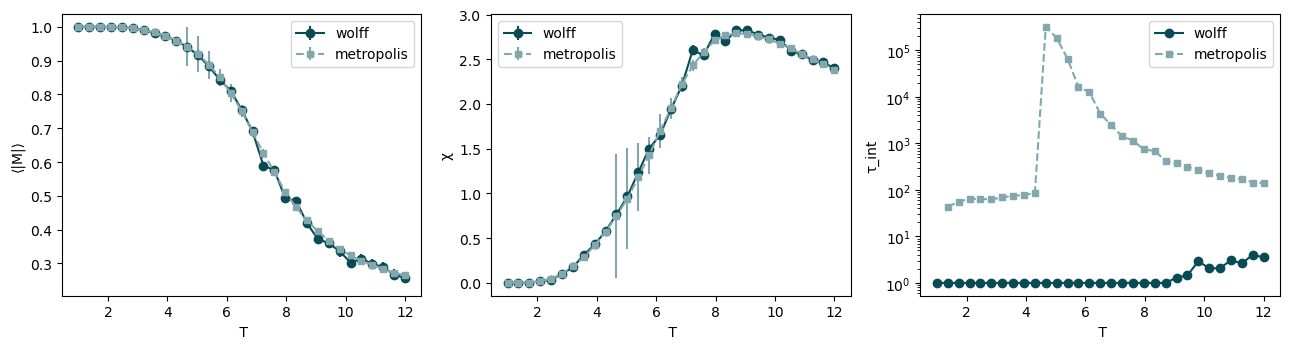

In [8]:

from matplotlib.colors import ListedColormap

SPIN_CMAP = ListedColormap(["#094B55", "#82a8ae"])
c_dark, c_light = SPIN_CMAP.colors 
# ---------- plot ----------
fig, axs = plt.subplots(1, 3, figsize=(13, 3.6))

# ⟨|M|⟩
axs[0].errorbar(temperatures, Mw, yerr=Mw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[0].errorbar(temperatures, Mm, yerr=Mm_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[0].set_xlabel(" T")
axs[0].set_ylabel("⟨|M|⟩")
axs[0].legend()

# χ
axs[1].errorbar(temperatures, Chiw, yerr=Chiw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[1].errorbar(temperatures, Chim, yerr=Chim_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[1].set_xlabel(" T")
axs[1].set_ylabel("χ")
axs[1].legend()

# τ_int
axs[2].plot(temperatures, Tauw, 'o-',  ms=6, label='wolff',c=c_dark)
axs[2].plot(temperatures, Taum, 's--', ms=4, label='metropolis',c=c_light)
axs[2].set_xlabel(" T")
axs[2].set_yscale('log')
axs[2].set_ylabel("τ_int")
axs[2].legend()

# plt.savefig('ising_test')

plt.tight_layout()
plt.show()

### disorder system 20x20

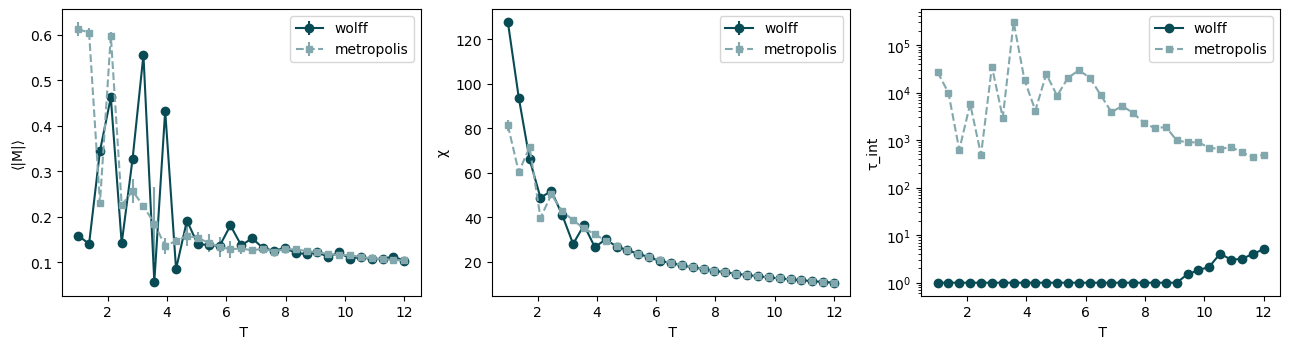

In [10]:

from matplotlib.colors import ListedColormap

SPIN_CMAP = ListedColormap(["#094B55", "#82a8ae"])
c_dark, c_light = SPIN_CMAP.colors 
# ---------- plot ----------
fig, axs = plt.subplots(1, 3, figsize=(13, 3.6))

# ⟨|M|⟩
axs[0].errorbar(temperatures, Mw, yerr=Mw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[0].errorbar(temperatures, Mm, yerr=Mm_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[0].set_xlabel(" T")
axs[0].set_ylabel("⟨|M|⟩")
axs[0].legend()

# χ
axs[1].errorbar(temperatures, Chiw, yerr=Chiw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[1].errorbar(temperatures, Chim, yerr=Chim_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[1].set_xlabel(" T")
axs[1].set_ylabel("χ")
axs[1].legend()

# τ_int
axs[2].plot(temperatures, Tauw, 'o-',  ms=6, label='wolff',c=c_dark)
axs[2].plot(temperatures, Taum, 's--', ms=4, label='metropolis',c=c_light)
axs[2].set_xlabel(" T")
axs[2].set_yscale('log')
axs[2].set_ylabel("τ_int")
axs[2].legend()

# plt.savefig('ising_test')

plt.tight_layout()
plt.show()

### disorder system 30x30

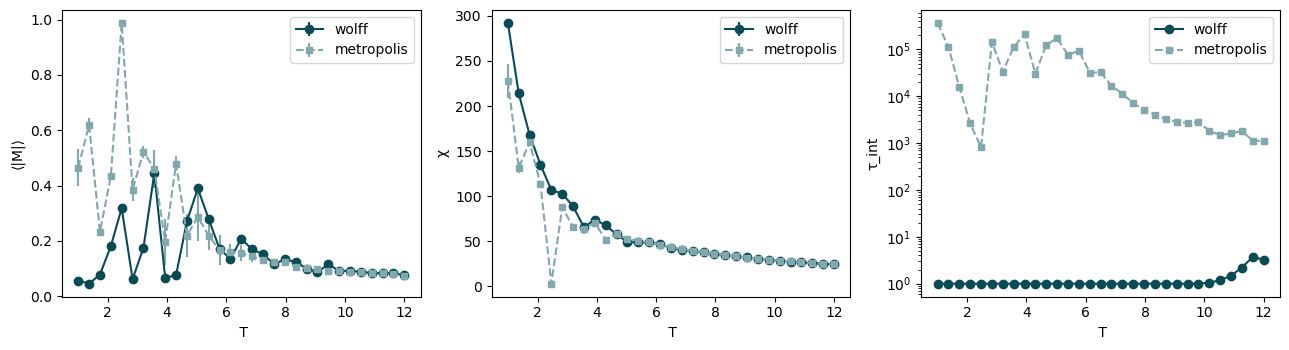

In [3]:

from matplotlib.colors import ListedColormap

SPIN_CMAP = ListedColormap(["#094B55", "#82a8ae"])
c_dark, c_light = SPIN_CMAP.colors 
# ---------- plot ----------
fig, axs = plt.subplots(1, 3, figsize=(13, 3.6))

# ⟨|M|⟩
axs[0].errorbar(temperatures, Mw, yerr=Mw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[0].errorbar(temperatures, Mm, yerr=Mm_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[0].set_xlabel(" T")
axs[0].set_ylabel("⟨|M|⟩")
axs[0].legend()

# χ
axs[1].errorbar(temperatures, Chiw, yerr=Chiw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[1].errorbar(temperatures, Chim, yerr=Chim_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[1].set_xlabel(" T")
axs[1].set_ylabel("χ")
axs[1].legend()

# τ_int
axs[2].plot(temperatures, Tauw, 'o-',  ms=6, label='wolff',c=c_dark)
axs[2].plot(temperatures, Taum, 's--', ms=4, label='metropolis',c=c_light)
axs[2].set_xlabel(" T")
axs[2].set_yscale('log')
axs[2].set_ylabel("τ_int")
axs[2].legend()

# plt.savefig('ising_test')

plt.tight_layout()
plt.show()

### exploring the unexpected oscillation in magnetization 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lattice import Lattice
from monte_carlo import MonteCarlo

# magnet_m = [] #np.zeros_like((10,1_000_000))
# magnet_w = [] #np.zeros_like((10,1_000))

        

def run_one_method(method, temperatures, rows, cols, doping, kf, J0, warmup, steps):
    Mabs_mean, Mabs_err = [], []
    Chi_mean,  Chi_err  = [], []
    Tau_list            = []

    for T in temperatures:
        lat = Lattice(rows=rows,cols=cols,doping=doping,kf=kf,J0=J0)      # J = -1.0 for ferro with your ΔE
        mc  = MonteCarlo(lat)
        mc.run_loop(warmup_steps=warmup, steps=steps, T=T, method=method)

        m = np.asarray(mc.acc.magnetization)   # raw magnetization series (can be ±)
        # order parameter
        m_abs = np.abs(m)
        # if method=="metropolis":
        #     magnet_m.append(m)
        # else:
        #     magnet_w.append(m)
        

        acf   = mc.acc.autocorr_fft(m)                # use raw m for tau
        tau   = mc.acc.tau_int_from_acf(acf)
        Tau_list.append(tau)

        N   = m.size
        Mabs_mean.append(m_abs.mean())
        Mabs_err.append(np.sqrt(m_abs.var(ddof=1) * 2.0 * tau / N))

        Chi_mean.append(np.mean(mc.acc.susceptibility))
        Chi_err.append(np.sqrt(np.var(mc.acc.susceptibility,ddof=1) * 2.0 * tau / N))

    return (np.array(Mabs_mean), np.array(Mabs_err),
            np.array(Chi_mean),  np.array(Chi_err),
            np.array(Tau_list))

temperatures = [1]# np.linspace(1., 4.0, 10)
rows, cols = 10, 10
doping = 0.3
kf = 0.3
J0 = -1               

# Heavier sampling for Metropolis (critical slowing down)
warmup_w = 1000; steps_w = 10_000
warmup_m = 100_000; steps_m = 1_000_000

# ---------- run both ----------
Mw, Mw_err, Chiw, Chiw_err, Tauw = run_one_method("wolff", temperatures, rows, cols, doping, kf, J0, warmup_w, steps_w)
# Mm, Mm_err, Chim, Chim_err, Taum = run_one_method("metropolis", temperatures, rows, cols, doping, kf, J0, warmup_m, steps_m)



Starting warmup phase...


100%|██████████| 1000/1000 [00:53<00:00, 18.87it/s]


GIF saved to wolff_1_warmup.gif
Starting production phase...


100%|██████████| 10000/10000 [00:01<00:00, 5172.78it/s]


Starting warmup phase...


100%|██████████| 100000/100000 [00:05<00:00, 17007.60it/s]


ValueError: all input arrays must have the same shape

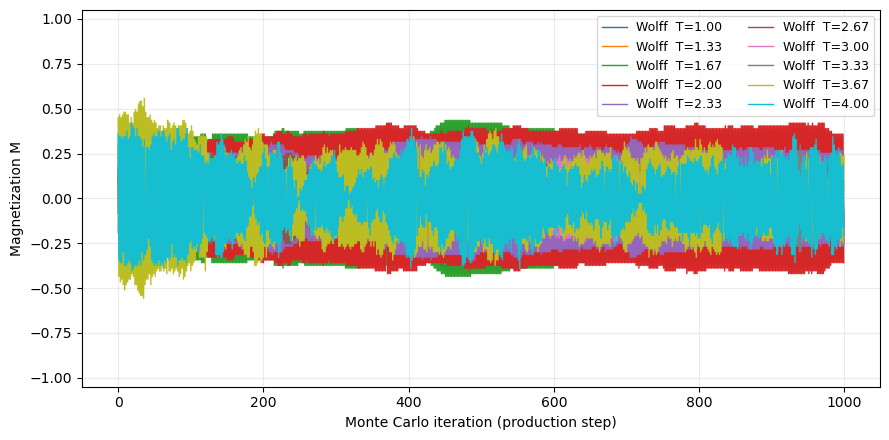

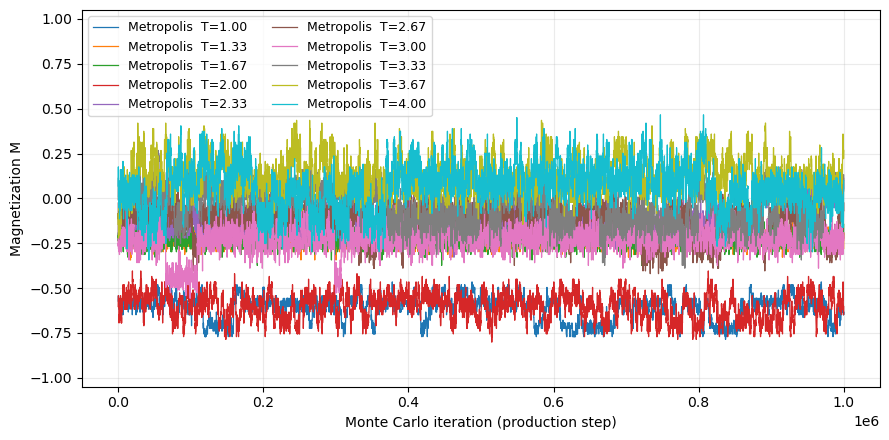

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---- helpers ----
def thin_series(y, max_points=5000):
    n = len(y)
    if n <= max_points:
        return np.arange(n), y
    stride = int(np.ceil(n / max_points))
    return np.arange(0, n, stride), y[::stride]

# Set your desired axis limits here (leave as None to auto)
xlim_w = None          # e.g. (0, 1000)
ylim_w = (-1.05, 1.05) # reasonable for Ising spins in [-1,1]

xlim_m = None          # e.g. (0, 200_000)
ylim_m = (-1.05, 1.05)

# ---- Wolff traces ----
plt.figure(figsize=(9, 4.5))
for T, m in zip(temperatures, magnet_w):
    x, y = thin_series(np.asarray(m), max_points=8000)
    plt.plot(x, y, lw=1.0, label=f"Wolff  T={T:.2f}")

plt.xlabel("Monte Carlo iteration (production step)")
plt.ylabel("Magnetization M")
if xlim_w: plt.xlim(*xlim_w)
if ylim_w: plt.ylim(*ylim_w)
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# ---- Metropolis traces ----
plt.figure(figsize=(9, 4.5))
for T, m in zip(temperatures, magnet_m):
    x, y = thin_series(np.asarray(m), max_points=8000)
    plt.plot(x, y, lw=0.9, label=f"Metropolis  T={T:.2f}")

plt.xlabel("Monte Carlo iteration (production step)")
plt.ylabel("Magnetization M")
if xlim_m: plt.xlim(*xlim_m)
if ylim_m: plt.ylim(*ylim_m)
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


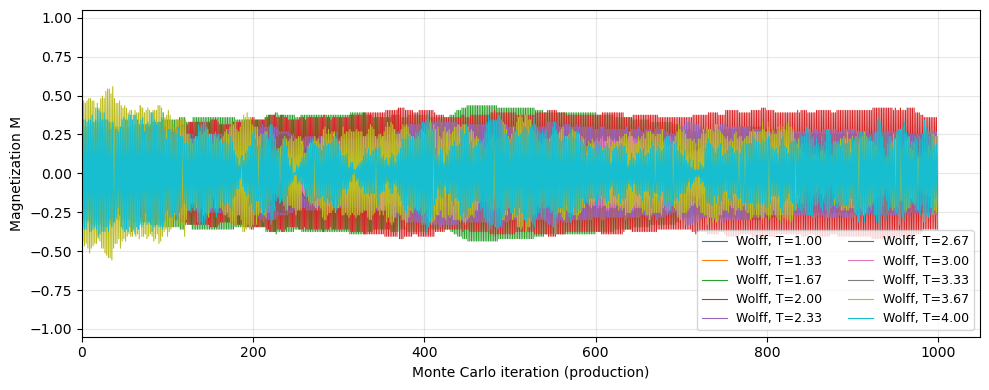

/tmp/ipykernel_11062/1979388550.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/lisa/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


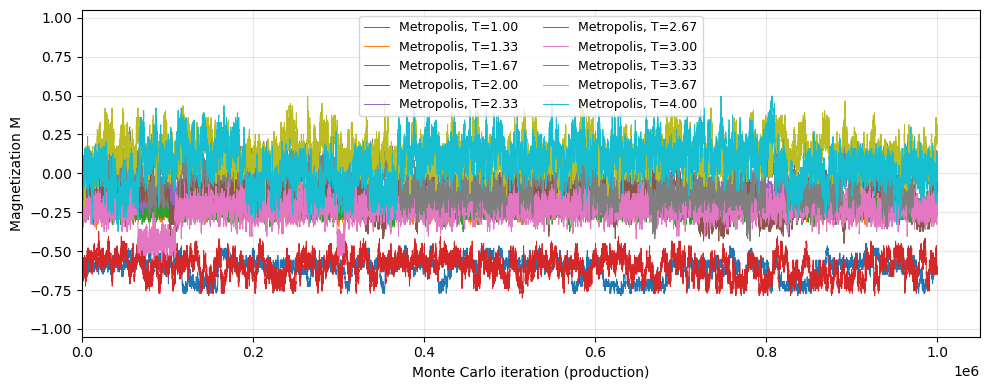

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- настройки осей (если нужны явные пределы; иначе оставьте None) ---
xlim_w = (0, None)          # например (0, 1000) или None
xlim_m = (0, None)
ylim   = (-1.05, 1.05)      # спины в [-1, 1]

# ---------- Wolff ----------
plt.figure(figsize=(10, 4))
for T, m in zip(temperatures, magnet_w):
    x = np.arange(len(m))
    plt.plot(x, m, lw=0.8, label=f"Wolff, T={T:.2f}")
plt.xlabel("Monte Carlo iteration (production)")
plt.ylabel("Magnetization M")
if xlim_w is not None: plt.xlim(xlim_w)
if ylim   is not None: plt.ylim(ylim)
plt.grid(alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# ---------- Metropolis ----------
plt.figure(figsize=(10, 4))
for T, m in zip(temperatures, magnet_m):
    x = np.arange(len(m))
    plt.plot(x, m, lw=0.7, label=f"Metropolis, T={T:.2f}")
plt.xlabel("Monte Carlo iteration (production)")
plt.ylabel("Magnetization M")
if xlim_m is not None: plt.xlim(xlim_m)
if ylim   is not None: plt.ylim(ylim)
plt.grid(alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


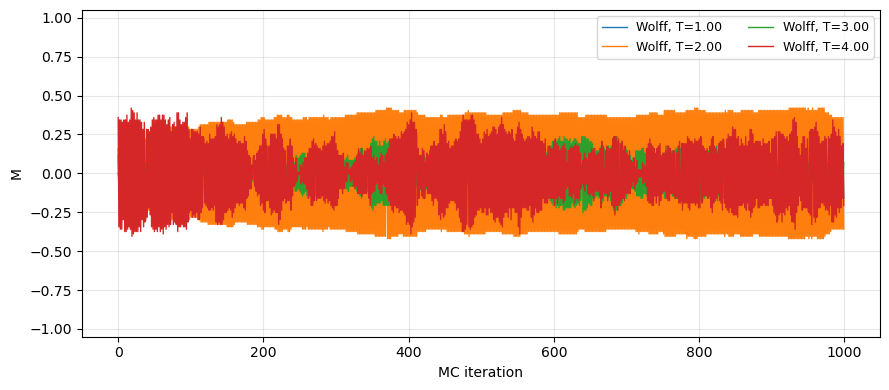

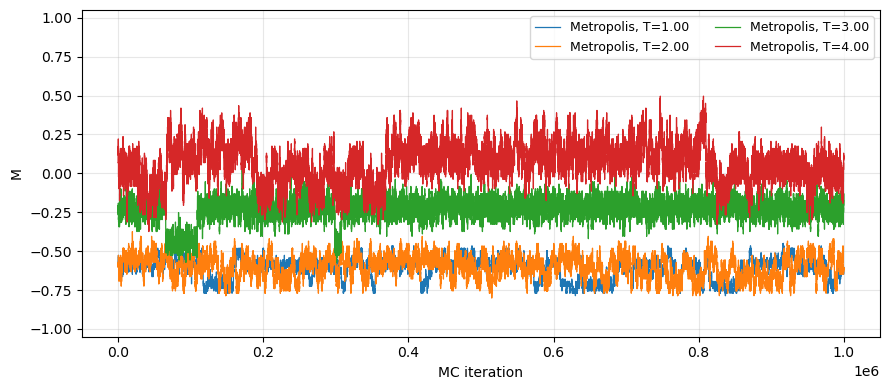

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# pick a few temps to plot
chosen_T = [1., 2.,3., 4.0]   # example

# map each chosen T to the nearest available temperature index
temps = np.asarray(temperatures)
idx = [int(np.argmin(np.abs(temps - t))) for t in chosen_T]

# Wolff
plt.figure(figsize=(9,4))
for i in idx:
    m = np.asarray(magnet_w[i])
    plt.plot(np.arange(len(m)), m, lw=1.0, label=f"Wolff, T={temps[i]:.2f}")
plt.xlabel("MC iteration"); plt.ylabel("M"); plt.ylim(-1.05, 1.05)
plt.grid(alpha=0.3); plt.legend(ncol=2, fontsize=9); plt.tight_layout(); plt.show()

# Metropolis
plt.figure(figsize=(9,4))
for i in idx:
    m = np.asarray(magnet_m[i])
    plt.plot(np.arange(len(m)), m, lw=0.9, label=f"Metropolis, T={temps[i]:.2f}")
plt.xlabel("MC iteration"); plt.ylabel("M"); plt.ylim(-1.05, 1.05)
plt.grid(alpha=0.3); plt.legend(ncol=2, fontsize=9); plt.tight_layout(); plt.show()


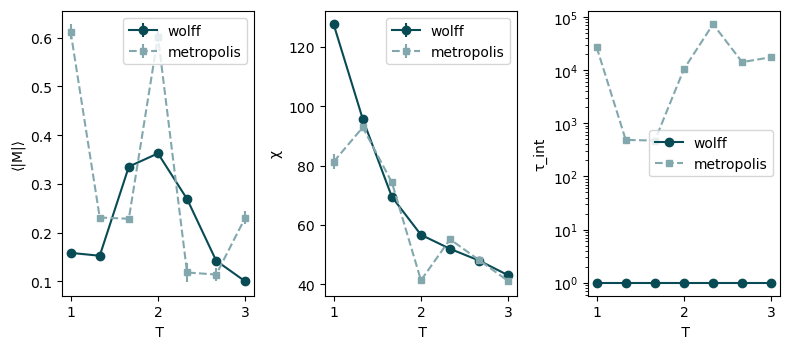

In [3]:

from matplotlib.colors import ListedColormap

SPIN_CMAP = ListedColormap(["#094B55", "#82a8ae"])
c_dark, c_light = SPIN_CMAP.colors 
# ---------- plot ----------
fig, axs = plt.subplots(1, 3, figsize=(8, 3.6))

# ⟨|M|⟩
axs[0].errorbar(temperatures, Mw, yerr=Mw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[0].errorbar(temperatures, Mm, yerr=Mm_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[0].set_xlabel(" T")
axs[0].set_ylabel("⟨|M|⟩")
axs[0].legend()

# χ
axs[1].errorbar(temperatures, Chiw, yerr=Chiw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
axs[1].errorbar(temperatures, Chim, yerr=Chim_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[1].set_xlabel(" T")
axs[1].set_ylabel("χ")
axs[1].legend()

# τ_int
axs[2].plot(temperatures, Tauw, 'o-',  ms=6, label='wolff',c=c_dark)
axs[2].plot(temperatures, Taum, 's--', ms=4, label='metropolis',c=c_light)
axs[2].set_xlabel(" T")
axs[2].set_yscale('log')
axs[2].set_ylabel("τ_int")
axs[2].legend()

# plt.savefig('ising_test')

plt.tight_layout()
plt.show()

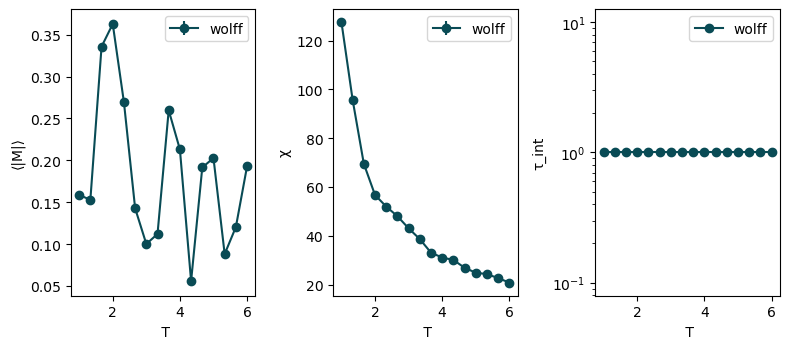

In [6]:

from matplotlib.colors import ListedColormap

SPIN_CMAP = ListedColormap(["#094B55", "#82a8ae"])
c_dark, c_light = SPIN_CMAP.colors 
# ---------- plot ----------
fig, axs = plt.subplots(1, 3, figsize=(8, 3.6))

# ⟨|M|⟩
axs[0].errorbar(temperatures, Mw, yerr=Mw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
# axs[0].errorbar(temperatures, Mm, yerr=Mm_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[0].set_xlabel(" T")
axs[0].set_ylabel("⟨|M|⟩")
axs[0].legend()

# χ
axs[1].errorbar(temperatures, Chiw, yerr=Chiw_err, fmt='o-', ms=6, label='wolff',c=c_dark)
# axs[1].errorbar(temperatures, Chim, yerr=Chim_err, fmt='s--', ms=4, label='metropolis',c=c_light)
axs[1].set_xlabel(" T")
axs[1].set_ylabel("χ")
axs[1].legend()

# τ_int
axs[2].plot(temperatures, Tauw, 'o-',  ms=6, label='wolff',c=c_dark)
# axs[2].plot(temperatures, Taum, 's--', ms=4, label='metropolis',c=c_light)
axs[2].set_xlabel(" T")
axs[2].set_yscale('log')
axs[2].set_ylabel("τ_int")
axs[2].legend()

# plt.savefig('ising_test')

plt.tight_layout()
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

PALETTE = [
    "#C87568", 
    "#D9A79A",  
    "#D5963C",  
    "#2F365A",  
    "#7B6886",  
]

MY_CMAP = ListedColormap(PALETTE, name="custom5")
